# Solving Bogoliubov-de Gennes equations and Gap equations
We consider two-dimensional s-wave superconductor. 

In [1]:
using Pkg
Pkg.add(PackageSpec(name="RSCG",rev = "master"))
using RSCG

     Cloning git-repo `https://github.com/cometscome/RSCG.jl.git`
    Updating git-repo `https://github.com/cometscome/RSCG.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed LinearMaps ─ v3.6.1
    Updating `~/.julia/environments/v1.7/Project.toml`
  [4e41d8b6] + RSCG v0.1.1 `https://github.com/cometscome/RSCG.jl.git#master`
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [7a12625a] + LinearMaps v3.6.1
  [4e41d8b6] + RSCG v0.1.1 `https://github.com/cometscome/RSCG.jl.git#master`
Precompiling project...
  ✓ LinearMaps
  ✓ RSCG
  2 dependencies successfully precompiled in 1 seconds (294 already precompiled)


In [2]:
using SparseArrays

function make_hamiltonian(Nx,Ny,Δ,μ)
    N = Nx*Ny
    H = spzeros(ComplexF64,2N,2N)
    t = 1.0
    ds = [(0,0),(1,0),(-1,0),(0,1),(0,-1)]
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            for d in ds
                jx = ix + d[1]
                jy = iy + d[2]
                jx += ifelse(jx > Nx,-Nx,0)
                jx += ifelse(jx < 1,Nx,0)
                jy += ifelse(jy > Ny,-Ny,0)
                jy += ifelse(jy < 1,Ny,0)
                j = (jy-1)*Nx + jx
                if jx == ix && jy == iy
                    H[i,j] += -μ
                else
                    H[i,j] += -t
                end
                
                H[i+N,j+N] += -conj(H[i,j])
            end  
            
            jx = ix
            jy = iy
            j = (jy-1)*Nx + jx
            
            H[i,j+N] += Δ[ix,iy]
            H[j+N,i] += conj(H[i,j+N])
        end
    end
    return H
end



make_hamiltonian (generic function with 1 method)

In [3]:
function update_H!(H,Δ)
    Nx,Ny = size(Δ)
    N = Nx*Ny
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            
            jx = ix
            jy = iy
            j = (jy-1)*Nx + jx
            
            H[i,j+N] = Δ[ix,iy]
            H[j+N,i] = conj(H[i,j+N])
        end
    end
end



update_H! (generic function with 1 method)

In [4]:
function fit_ir(Gij,smpl_Matsubara,smpl_beta)
    gl = fit(smpl_Matsubara, Gij)
    G0 = evaluate(smpl_beta, gl)
    return -G0[1]
end

function calc_Δ_ir!(Δnew,H,Δold,T,U,ωn,smpl_Matsubara,smpl_beta,;mixratio = 0.5)

    Nx,Ny = size(Δold)
    N = Nx*Ny
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            j = i + N
            Gij = greensfunctions(i,j,ωn,H) 
            G0 = fit_ir(Gij,smpl_Matsubara,smpl_beta)            
            Δi = U*G0            
            Δnew[ix,iy] = (1-mixratio)*Δold[ix,iy] + mixratio*Δi    
        end
    end
end



calc_Δ_ir! (generic function with 1 method)

In [5]:
function calc_ωn(T,ωc)
    M = Int((round(ωc/(T*π)))/2-1)
    println("num. of Matsubara freq: ",2M)
    ωn = zeros(ComplexF64,2M)
    for n=1:2M
        ωn[n] = π*T*(2.0*(n-M-1)+1)*im
    end
    return ωn
end

function calc_Δ!(Δnew,H,Δold,T,U,ωn;mixratio = 0.5)
    Nx,Ny = size(Δold)
    N = Nx*Ny
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            j = i + N
            Gij = greensfunctions(i,j,ωn,H) 
            Δi = U*T*sum(Gij)
            Δnew[ix,iy] = (1-mixratio)*Δold[ix,iy] + mixratio*Δi    
        end
    end
end

calc_Δ! (generic function with 1 method)

In [6]:
using SparseIR
T = 0.05

beta = 1/T
wmax = 10.0

basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)
smpl = MatsubaraSampling(basis)
ωn = smpl.sampling_points .* (im * π/beta)
println("num. of Matsubara freqs. ", length(ωn))
smpl_beta = TauSampling(basis, [beta])

U  =-2
itemax = 1000
μ = -0.2

Nx = 20
Ny = 20
Δ = ones(ComplexF64,Nx,Ny)
Δold = copy(Δ)
Δnew = zero(Δ)
H = make_hamiltonian(Nx,Ny,Δold,μ)

ix = Nx ÷ 2
iy = Ny ÷ 2
i = (iy-1)*Nx + ix
j = i


for ite = 1:itemax
    calc_Δ_ir!(Δnew,H,Δold,T,U,ωn,smpl,smpl_beta)
    #calc_Δ!(Δnew,H,Δold,T,U,ωn2)
    update_H!(H,Δnew)
    eps = sum(abs.(Δnew-Δold))/sum(abs.(Δold))
    println("$ite $eps ",Δnew[ix,iy])
    Δold .= Δnew
    if eps < 1e-6
        break
    end
end

num. of Matsubara freqs. 30
1 0.1970941450229605 0.8029058549770395 - 5.46104727332768e-15im
2 0.15787367222268378 0.6761481592026459 - 1.0513376894487245e-14im
3 0.12565203071793377 0.5911887699349736 - 1.0760666815909707e-14im
4 0.09961174945406608 0.5322994230445646 - 1.6635198636794365e-14im
5 0.07878716855818718 0.490361053714108 - 2.401474822531295e-14im
6 0.062242811851004116 0.4598396046836746 - 2.805531451728743e-14im
7 0.049149947261247856 0.4372385164288109 - 3.1486331328943926e-14im
8 0.038810120863390314 0.4202692369248294 - 3.311562050639408e-14im
9 0.030651990847311596 0.4073871392882944 - 3.521147629584446e-14im
10 0.02421659433752495 0.39752159159263234 - 3.823416035490349e-14im
11 0.019139211630043965 0.3899133636348928 - 4.1658289754626066e-14im
12 0.015131780526092434 0.3840132801609512 - 4.485629622360031e-14im
13 0.01196728148108836 0.37941768478677174 - 4.957879725049447e-14im
14 0.009467253058406507 0.3758256333312678 - 5.509730080218671e-14im
15 0.0074913209888

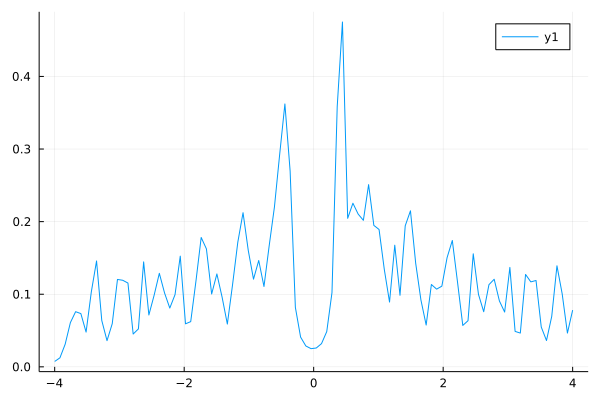

In [7]:
using Plots
M = 100
σ = zeros(ComplexF64,M)
η = 0.05
σmin = -4.0 + im*η
σmax = 4.0+ im*η
for i=1:M
    σ[i] = (i-1)*(σmax-σmin)/(M-1) + σmin
end

Gij1 = greensfunctions(i,j,σ,H) 
plot(real.(σ),(-1/π)*imag.(Gij1))

